In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data
from VAE_utils import Encoder, Decoder, Prior, ELBO, train_vae, VAElinear

In [28]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n, )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return label, torch.normal(x, sigma)


labels, samples = two_moons(16384)
labels = labels.view(-1, 1)           # <- make it (B,1)


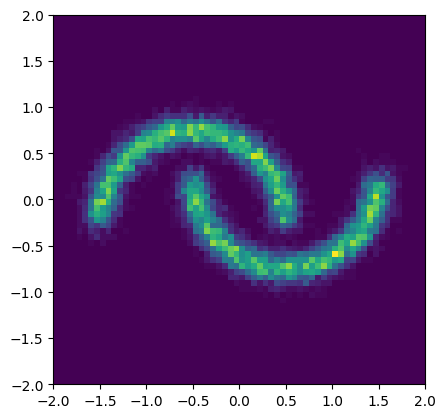

In [29]:
plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

In [30]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAElinear(nn.Module):
    """
    Conditional VAE (MLP) with heteroscedastic decoder:
      q_phi(z|x,y)  -> outputs mu_z, log_var_z
      p_theta(x|z,y)-> outputs mu_x, log_var_x   (variance learned)

    x: R^{in_size},  y: R^{cond_in},  z: R^{latent_s}
    """

    def __init__(self, **kwargs):
        super().__init__()
        # Required
        self.latent_s = kwargs['latent_s']
        self.in_size  = kwargs['in_size']
        self.cond_in  = kwargs['cond_in']

        # Optional
        enc_w = kwargs.get('enc_w', 128)
        enc_l = kwargs.get('enc_l', 2)
        dec_w = kwargs.get('dec_w', 128)
        dec_l = kwargs.get('dec_l', 2)
        gpu   = kwargs.get('gpu', True)

        # Device
        self.device = torch.device("cuda:0" if (gpu and torch.cuda.is_available()) else "cpu")

        # Encoder: [x||y] -> [mu_z || log_var_z]
        enc_sizes = [self.in_size + self.cond_in] + [enc_w] * enc_l + [2 * self.latent_s]
        enc_layers = []
        for a, b in zip(enc_sizes[:-1], enc_sizes[1:]):
            enc_layers += [nn.Linear(a, b), nn.ReLU()]
        enc_layers.pop()                       # drop last ReLU
        self.enc = nn.Sequential(*enc_layers)

        # Decoder: [z||y] -> [mu_x || log_var_x]
        dec_sizes = [self.latent_s + self.cond_in] + [dec_w] * dec_l + [2 * self.in_size]
        dec_layers = []
        for a, b in zip(dec_sizes[:-1], dec_sizes[1:]):
            dec_layers += [nn.Linear(a, b), nn.ReLU()]
        dec_layers.pop()                       # drop last ReLU
        self.dec = nn.Sequential(*dec_layers)

        self.to(self.device)

    # -------- helpers --------
    def _ensure_2d(self, t):
        if t.dim() > 2:
            return t.view(t.size(0), -1)
        return t

    def encode(self, x, y):
        x = self._ensure_2d(x)
        y = self._ensure_2d(y)
        h = torch.cat([x, y], dim=1)
        mu_z, log_var_z = torch.split(self.enc(h), self.latent_s, dim=1)
        return mu_z, log_var_z

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        out = self.dec(zy)
        mu_x, log_var_x = torch.split(out, self.in_size, dim=1)
        # Clamp log-variance for numerical stability
        log_var_x = torch.clamp(log_var_x, min=-6.0, max=4.0)
        return mu_x, log_var_x

    # -------- core API --------
    def loss(self, x0, cond_in=None, beta: float = 1.0):
        """
        ELBO = E_q[ -log p(x|z,y) ] + beta * KL(q||p)
        -log p(x|z,y) for Gaussian = 0.5 * [ log_var_x + (x-mu_x)^2 / exp(log_var_x) ] (const dropped)
        """
        x0 = self._ensure_2d(x0).to(self.device)
        bs = x0.size(0)

        if cond_in is None:
            cond_in = torch.zeros(bs, self.cond_in, device=self.device, dtype=x0.dtype)
        else:
            cond_in = self._ensure_2d(cond_in).to(dtype=x0.dtype, device=self.device)

        # q(z|x,y)
        mu_z, log_var_z = self.encode(x0, cond_in)
        z = self.reparameterize(mu_z, log_var_z)

        # p(x|z,y)
        mu_x, log_var_x = self.decode(z, cond_in)

        # Gaussian NLL (per-sample sum over dims)
        inv_var_x = torch.exp(-log_var_x)
        recon_nll = 0.5 * (log_var_x + (x0 - mu_x).pow(2) * inv_var_x)
        recon = recon_nll.sum(dim=1).mean()

        # KL(q(z|x,y) || N(0,I))
        kl = 0.5 * (torch.exp(log_var_z) + mu_z.pow(2) - 1.0 - log_var_z)
        kl = kl.sum(dim=1).mean()

        total = recon + beta * kl
        return total, {'recon': recon.detach(), 'kl': kl.detach()}

    @torch.no_grad()
    def forward(self, x0, cond_in=None, return_latent=False):
        self.eval()
        x0 = self._ensure_2d(x0).to(self.device)
        bs = x0.size(0)
        if cond_in is None:
            cond_in = torch.zeros(bs, self.cond_in, device=self.device, dtype=x0.dtype)
        else:
            cond_in = self._ensure_2d(cond_in).to(dtype=x0.dtype, device=self.device)

        mu_z, log_var_z = self.encode(x0, cond_in)
        z = self.reparameterize(mu_z, log_var_z)
        mu_x, log_var_x = self.decode(z, cond_in)
        if return_latent:
            return (mu_x, log_var_x), (mu_z, log_var_z, z)
        return mu_x

    def to(self, device):
        ret = super().to(device)
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        return ret

    @torch.no_grad()
    def sample(self, n: int, c, sample_mean: bool = False, var_scale: float = 1.0):
        """
        Vectorized sampler with the same logic as Generator.sample:
          - c: (B, cond_in) or (cond_in,) or (B,)  -> normalized to (B, cond_in)
          - returns: (S=n, B, in_size)

        Args:
            n           : number of samples per context (S)
            c           : context(s)
            sample_mean : if True, return decoder mean instead of stochastic sample
            var_scale   : multiply the predictive variance by this factor during sampling
        """
        self.eval()
        device = self.device

        # --- normalize context to (B, cond_in) ---
        if not isinstance(c, torch.Tensor):
            c = torch.tensor(c, dtype=torch.float32, device=device)
        else:
            c = c.to(device=device, dtype=torch.float32)

        if c.dim() == 1:
            # either (cond_in,) or (B,) scalar context; if scalar-per-sample, expand to (B,1)
            if c.numel() == self.cond_in:
                c = c.view(1, -1)  # single context -> (1, cond_in)
            else:
                c = c.view(-1, 1)  # per-sample scalar -> (B, 1)

        elif c.dim() == 2:
            pass  # already (B, cond_in)
        else:
            # flatten any higher dims: (B, *, cond_in) -> (B, cond_in)
            c = c.view(c.size(0), -1)

        B = c.size(0)
        assert c.size(1) == self.cond_in, f"Context dim mismatch: got {c.size(1)}, expected {self.cond_in}"

        # --- draw latent z for each (S,B) pair ---
        z = torch.randn(n * B, self.latent_s, device=device)

        # --- repeat context for each of the S samples ---
        c_rep = c.repeat(n, 1)  # (S*B, cond_in)

        # --- decode to (S*B, in_size) params ---
        mu_x, log_var_x = self.decode(z, c_rep)

        if sample_mean:
            x = mu_x
        else:
            std = torch.exp(0.5 * log_var_x) * (var_scale ** 0.5)
            eps = torch.randn_like(std)
            x = mu_x + std * eps

        # --- reshape to (S, B, in_size) ---
        x = x.view(n, B, self.in_size)
        return x

    @torch.no_grad()
    def quantiles(self, c, q=(0.25, 0.5, 0.75), n: int = 100, sample_mean: bool = False, var_scale: float = 1.0):
        """
        Match Generator.quantiles:
          - c: flexible shapes as in .sample
          - returns np.array with shape (len(q), B, in_size)
        """
        y = self.sample(n=n, c=c, sample_mean=sample_mean, var_scale=var_scale)  # (S, B, D)
        y = y.detach().cpu().numpy()
        qv = np.quantile(y, q, axis=0)  # (len(q), B, D)
        return qv

vae = VAElinear(latent_s=8, in_size=2, cond_in=1, gpu=True, enc_w=128, enc_l=3, dec_w=128, dec_l=3)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

EPOCHS = 100
for epoch in range(EPOCHS):
    vae.train()
    beta = min(1.0, (epoch+1) / 50)  # warm-up KL over ~50 epochs
    running = 0.0
    for c, x in trainloader:
        c = c.to(vae.device)
        x = x.to(vae.device)
        if c.dim() == 1:                   # (B,) -> (B,1)
            c = c.unsqueeze(1)
        loss, logs = vae.loss(x, c, beta=beta)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        running += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | loss={running/len(trainloader):.4f} "
              f"(recon={logs['recon'].item():.4f}, kl={beta*logs['kl'].item():.4f}, beta={beta:.2f})")


Epoch 010 | loss=-4.3156 (recon=-5.5657, kl=1.2629, beta=0.20)
Epoch 020 | loss=-3.3310 (recon=-5.4536, kl=2.0234, beta=0.40)
Epoch 030 | loss=-2.5418 (recon=-5.2403, kl=2.6470, beta=0.60)
Epoch 040 | loss=-1.7696 (recon=-5.1407, kl=3.1230, beta=0.80)
Epoch 050 | loss=-0.9898 (recon=-4.6299, kl=3.4417, beta=1.00)
Epoch 060 | loss=-1.1028 (recon=-3.5605, kl=3.3299, beta=1.00)
Epoch 070 | loss=-1.1102 (recon=-3.7043, kl=2.9963, beta=1.00)
Epoch 080 | loss=-1.1835 (recon=-4.0293, kl=2.9715, beta=1.00)
Epoch 090 | loss=-1.1252 (recon=-4.4774, kl=3.5252, beta=1.00)
Epoch 100 | loss=-1.0574 (recon=-4.3408, kl=2.9255, beta=1.00)


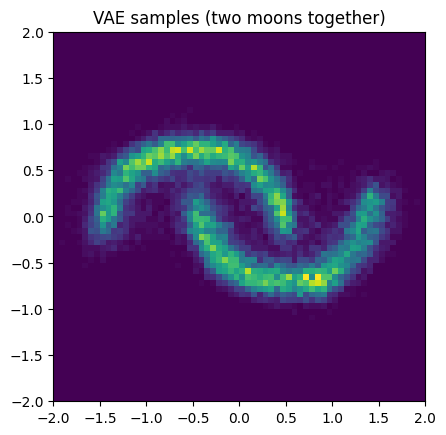

In [32]:
vae.eval()
with torch.no_grad():
    S = 10000
    y0 = vae.sample(n=S, c=torch.tensor([0.0], device=vae.device))[:, 0, :]
    y1 = vae.sample(n=S, c=torch.tensor([1.0], device=vae.device))[:, 0, :]

    # stack both moons together
    y_all = torch.cat([y0, y1], dim=0).cpu().numpy()

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(y_all[:, 0], y_all[:, 1], bins=64, range=((-2, 2), (-2, 2)))
plt.title("VAE samples (two moons together)")
plt.show()

In [33]:
encoder = Encoder(z_dim=8, c_dim=1, x_dim=2)
decoder = Decoder(z_dim=8, c_dim=1, x_dim=2)
prior = Prior(c_dim=1, z_dim=8)
elbo = ELBO(encoder, decoder, prior)

In [34]:
elbo_trained = train_vae(elbo, trainloader, epochs=100)

Epoch 1/100 - Loss: 48.8239 - Recon: -48.8228 - KL: 0.4666 - Beta: 0.003
Epoch 2/100 - Loss: 2.2496 - Recon: -2.2473 - KL: 0.3038 - Beta: 0.008
Epoch 3/100 - Loss: 1.9279 - Recon: -1.9231 - KL: 0.3689 - Beta: 0.013
Epoch 4/100 - Loss: 1.8643 - Recon: -1.8562 - KL: 0.4504 - Beta: 0.018
Epoch 5/100 - Loss: 1.8115 - Recon: -1.8000 - KL: 0.4943 - Beta: 0.023
Epoch 6/100 - Loss: 1.7158 - Recon: -1.6989 - KL: 0.5987 - Beta: 0.028
Epoch 7/100 - Loss: 1.5577 - Recon: -1.5326 - KL: 0.7508 - Beta: 0.033
Epoch 8/100 - Loss: 1.2912 - Recon: -1.2502 - KL: 1.0625 - Beta: 0.038
Epoch 9/100 - Loss: 1.0243 - Recon: -0.9493 - KL: 1.7181 - Beta: 0.044
Epoch 10/100 - Loss: 0.8512 - Recon: -0.7355 - KL: 2.3744 - Beta: 0.049
Epoch 11/100 - Loss: 0.5581 - Recon: -0.3856 - KL: 3.1983 - Beta: 0.054
Epoch 12/100 - Loss: -1.2152 - Recon: 1.7075 - KL: 8.2837 - Beta: 0.059
Epoch 13/100 - Loss: -3.8042 - Recon: 5.0116 - KL: 18.8157 - Beta: 0.064
Epoch 14/100 - Loss: -4.6254 - Recon: 6.2454 - KL: 23.4231 - Beta: 0.0

KeyboardInterrupt: 

In [ ]:
c = torch.full((10000, 1), 1.0, device="cuda")
z = elbo_trained.prior(c).sample()

x = elbo_trained.decoder(z, c).sample()

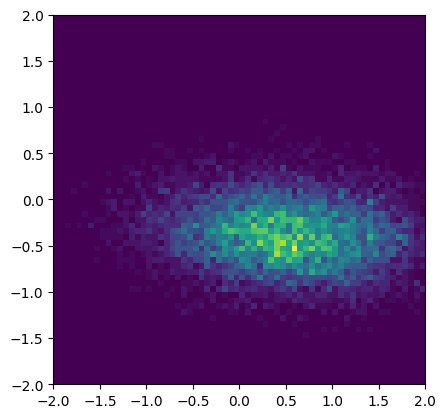

In [ ]:
plt.figure(figsize=(4.8, 4.8))
x = x.detach().cpu()
plt.hist2d(*x.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()